In [1]:
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
nyc_dem_link = 'https://gist.githubusercontent.com/kashuk/a08dc8f65b1b1aebafdcab9c0eda3346/raw/4d1cf7a306327f3570ddd6e4979e568ee82c2c71/dem_nyc_encoded.tif'

# Plot census data using geopandas

In [21]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame
import os
import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union #, unary_union
import h3
import base64
import urllib
import tempfile

import matplotlib.pyplot as plt



# directory with all gtfs zip files in it
directory = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/gtfs_zips'


In [3]:
zip_f = "nyc/tl_2020_36_tract.zip"

In [4]:
census_geo = gpd.read_file(zip_f)

In [5]:
census_geo.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."


In [6]:
census_geo.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [8]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [9]:
combined = census_geo.merge(commute, on='GEOID')

In [10]:
combined.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Workers 16 Years and Over: Worked At Home.1,Average Commute to Work (In Min)
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,...,1884,132,165,316,632,481,39,119,303,36
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,...,2627,181,565,494,751,545,25,66,613,29
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,...,1039,30,222,191,297,196,47,56,151,32


In [11]:
combined = combined.to_crs("EPSG:4326")
combined.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Public Transport

In [12]:
def get_stops_from_gtfs(path):
    feed = (gk.read_feed(path, dist_units='km'))
    return feed.get_stops()

def stops2hex(stops, resolution, hex_col):

    # find hexs containing the points
    stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,resolution),1)

    # aggregate the points
    stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

    #find center of hex for visualization
    stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    
    return stopsg

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['stop_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['stop_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

#Functions
def plot_scatter(df, metric_col, x='stop_lon', y='stop_lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax

In [13]:
# put all gtfs zips in one directory

# iterate over files in
# that directory
files = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files.append(f)

# Load all data and append to a single df
stops = pd.DataFrame()
for f in files:
    if stops.empty:
        stops = get_stops_from_gtfs(f) 
    else:
        temp_stops = get_stops_from_gtfs(f)
        stops = stops.append(temp_stops)

# convert all data to hex
resolution = 9
hex_col = 'hex'+str(resolution)
stops_hex = stops2hex(stops, resolution, hex_col)

In [14]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(stops_hex, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', stops_kring['cnt'].sum() / stops_hex['cnt'].sum())

sum sanity check: 1.0


# Census to Hex
https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

In [15]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")

In [16]:
METRIC_COL = 'Average Commute to Work (In Min)'

In [17]:
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


Text(0.5, 1.0, 'census tract: comutetime')

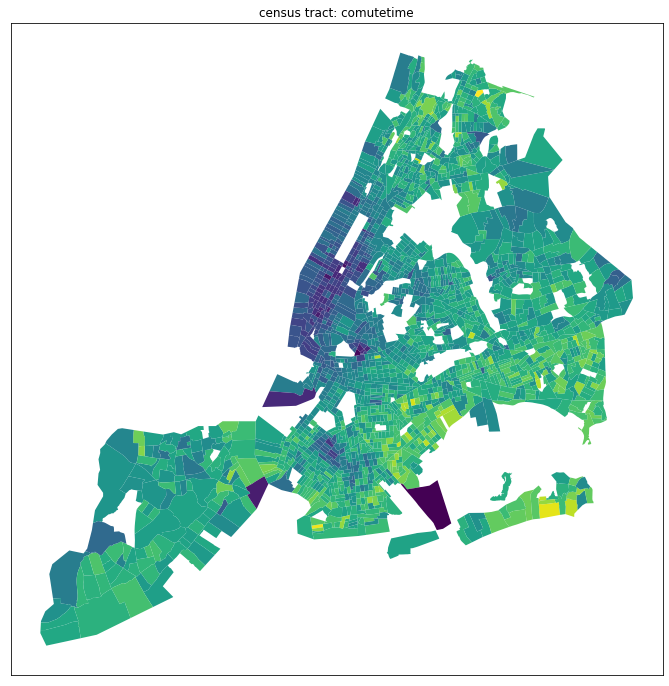

In [18]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: comutetime')

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


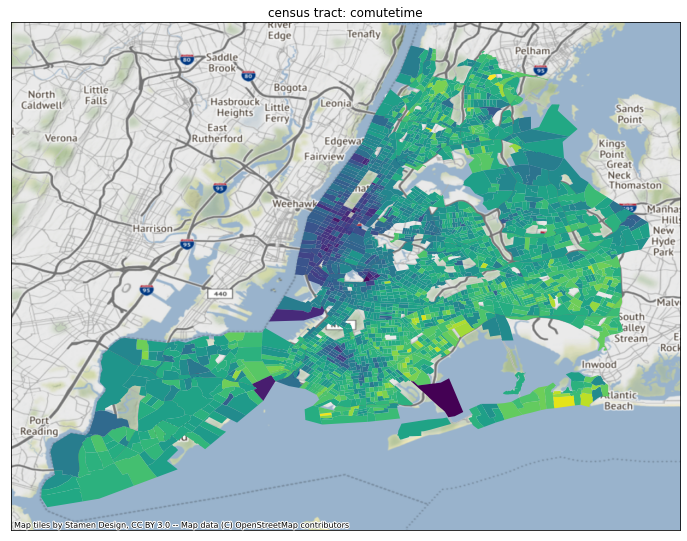

In [19]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: comutetime')
ctx.add_basemap(ax=ax, crs=gdf.crs)

In [ ]:
# Unify the CT boundries
union_poly = unary_union(gdf.geometry)

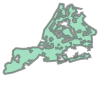

In [78]:
union_poly

In [79]:
APERTURE_SIZE = 10

In [80]:
# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_93346/2716173586.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for n,g in enumerate(union_poly):


0 
1 
2 
3 


In [81]:
# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

Sanity Check
number of hexes: 50233
number of duplicates: 0


In [82]:
# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [83]:
# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_93346/3302752611.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfh.crs = {"init": "epsg:4326"}


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_93346/2662139995.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Workers 16 Years and Over: Worked At Home.1,Average Commute to Work (In Min),index_right,hex10,lat,lng
3407,36,081,080900,36081080900,809,Census Tract 809,G5020,S,1001243,0,...,411,490,839,150,275,42,13673,8a2a100ee8affff,40.732847,-73.816670
4801,36,047,062800,36047062800,628,Census Tract 628,G5020,S,767918,272494,...,264,201,420,337,39,47,4771,8a2a1076e28ffff,40.586713,-73.923591
427,36,081,086900,36081086900,869,Census Tract 869,G5020,S,595378,18201,...,141,208,200,21,13,37,2210,8a2a100e07affff,40.761513,-73.832673


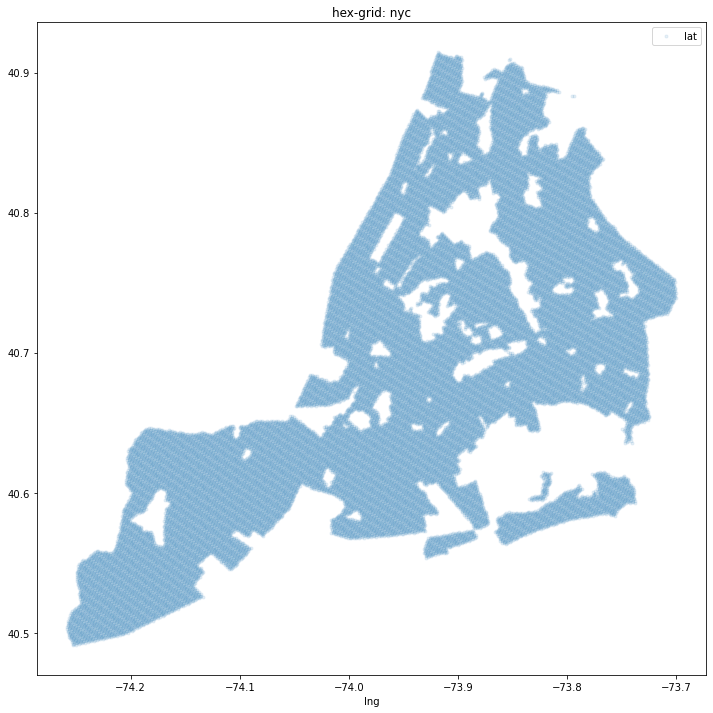

In [84]:
# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = gpd.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)


In [86]:
df_ct[METRIC_COL] = df_ct[METRIC_COL].astype(int)

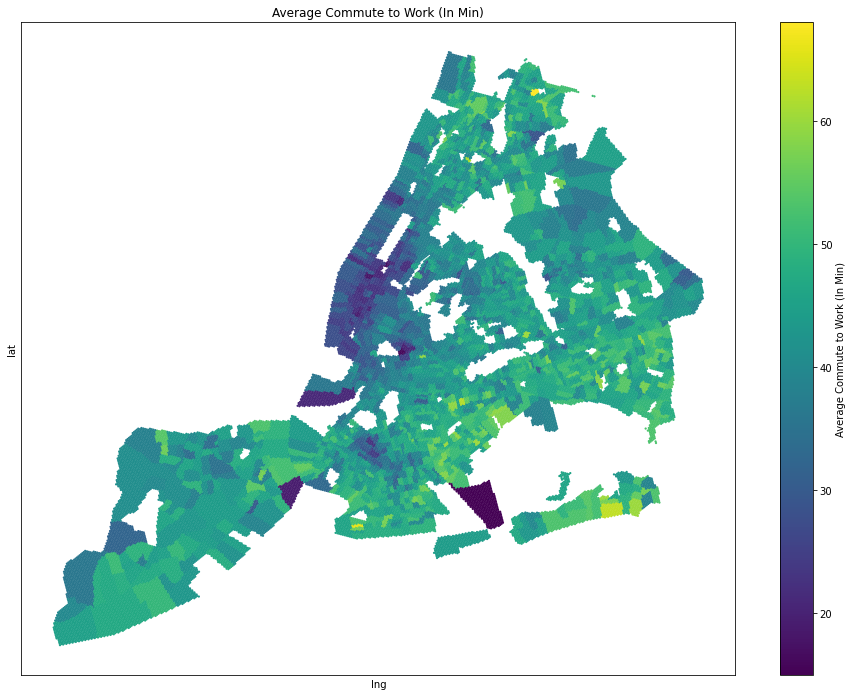

In [87]:
plot_scatter(pd.DataFrame(df_ct), metric_col=METRIC_COL, marker='.')

# Spatial weight smoothing

In [89]:
def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

In [90]:
def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc


Text(0, 0.5, 'Smoothing Coef')

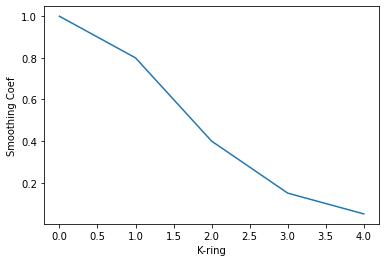

In [91]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

In [92]:
# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_93346/360021348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['hexk'] = df_agg[hex_col]


In [94]:
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())

sum sanity check: 1.0


Text(0.5, 1.0, 'hex-grid: smoothed comute time')

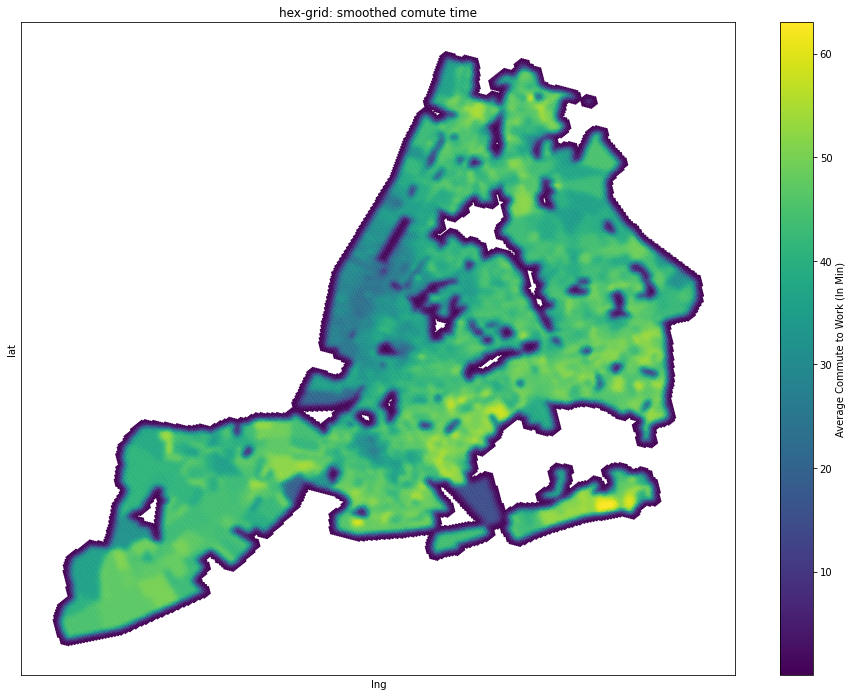

In [95]:
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed comute time')

In [98]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))

number of hex: 64581
number of coarse hex: 9569


In [99]:
df_coarse

,hex9,Average Commute to Work (In Min),lat,lng
0,892a1000003ffff,9.221675,40.858416,-73.781928
1,892a1000007ffff,2.837438,40.855826,-73.779693
2,892a100000bffff,33.051724,40.858308,-73.786214
3,892a100000fffff,23.320197,40.855718,-73.783978
4,892a1000013ffff,1.330049,40.861115,-73.779877
...,...,...,...,...
9564,892a10776cbffff,35.302463,40.674963,-74.021257
9565,892a10776cfffff,31.625616,40.672383,-74.019017
9566,892a10776d3ffff,29.987192,40.677777,-74.014958
9567,892a10776d7ffff,34.669951,40.675197,-74.012718


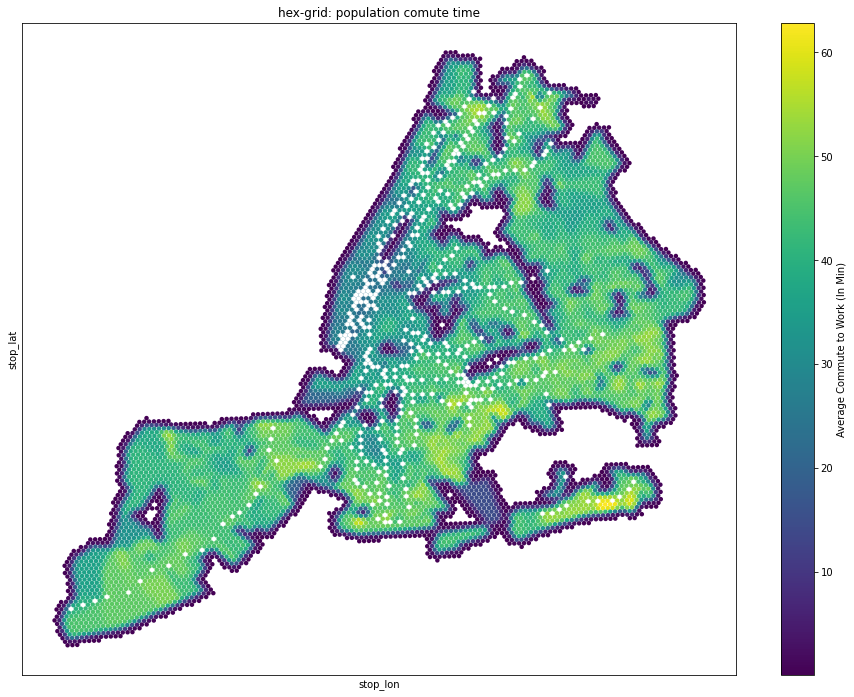

In [123]:
ax = plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
stops_hex.plot.scatter(ax=ax, y="stop_lat",c="white", x="stop_lon", marker='o',edgecolors='none')
plt.title('hex-grid: population comute time');

## Unifying data layers

,population,noise_complaints,stop
count,429.000000,429.000000,429.000000
mean,36.947674,44.251748,3.363636
std,9.001123,53.596206,1.227863
min,7.568473,1.000000,3.000000
25%,31.012808,7.000000,3.000000
50%,39.330049,18.000000,3.000000
75%,44.598522,59.000000,3.000000
max,47.324138,167.000000,15.000000


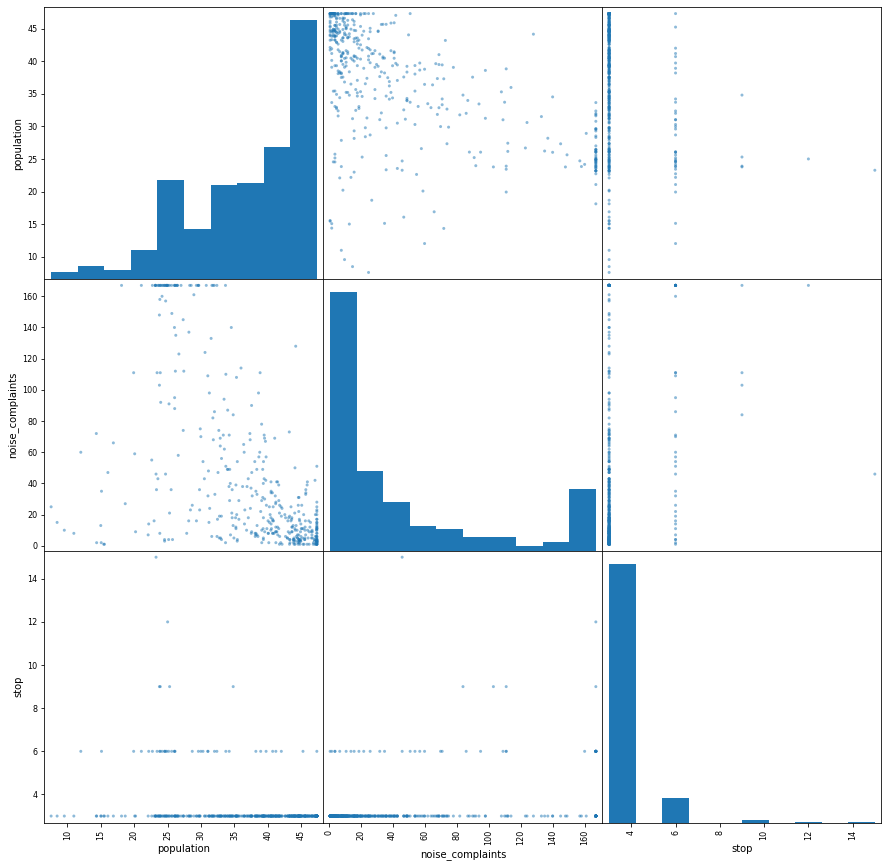

In [135]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(df311g[[hex_col,'cnt']]).merge(stops_hex[[hex_col,'cnt']].rename(columns={"cnt":"stop"}))
dfu.set_index(hex_col,inplace=True)
dfu.rename(index=str, columns={METRIC_COL: "population","cnt":"noise_complaints"},inplace=True)
dfu.population = dfu.population.clip(upper=dfu.population.quantile(.9))
dfu.noise_complaints = dfu.noise_complaints.clip(upper=dfu.noise_complaints.quantile(.9))
pd.plotting.scatter_matrix(dfu, alpha=0.5,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()

In [134]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 892a1001057ffff to 892a1077583ffff
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   population        429 non-null    float64
 1   noise_complaints  429 non-null    float64
 2   stop              429 non-null    float64
dtypes: float64(3)
memory usage: 13.4+ KB
